In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data\MNIST\raw\train-images-idx3-ubyte.gz to ../Data\MNIST\raw




Extracting ../Data\MNIST\raw\train-labels-idx1-ubyte.gz to ../Data\MNIST\raw




Extracting ../Data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../Data\MNIST\raw




Extracting ../Data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../Data\MNIST\raw

Processing...
Done!


C:\Users\yurit\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [8]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.48589641  accuracy:  78.400%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.09918170  accuracy:  85.358%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.02051938  accuracy:  88.478%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.10302212  accuracy:  90.192%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00202605  accuracy:  91.377%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.03254462  accuracy:  92.303%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.08636211  accuracy:  92.931%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00291313  accuracy:  93.408%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00108853  accuracy:  93.850%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.20231636  accuracy:  94.210%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.04835821  accuracy:  97.350%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00221250  accuracy:  97.675%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.03890292  accuracy:  97.783%
epoch:  1  b

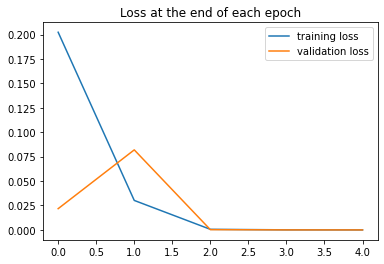

In [11]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [12]:
test_losses

[tensor(0.0218),
 tensor(0.0819),
 tensor(0.0003),
 tensor(3.1005e-05),
 tensor(7.9750e-06)]

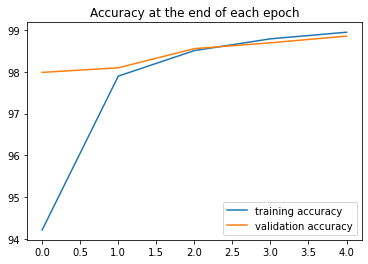

In [13]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [14]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [15]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9886/10000 =  98.860%


In [16]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    0    1    0    0    2    3    1    6    1]
 [   0 1133    1    0    1    0    2    5    1    3]
 [   0    0 1018    2    1    0    0    1    4    0]
 [   0    0    0  997    0    5    0    1    1    0]
 [   0    0    1    0  973    0    2    1    0    5]
 [   0    1    0    5    0  880    3    0    2    1]
 [   2    1    0    0    1    2  947    0    2    0]
 [   1    0    9    2    0    1    0 1015    0    0]
 [   0    0    2    3    2    0    1    1  951    4]
 [   0    0    0    1    4    2    0    3    7  995]]


In [17]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

114

In [18]:
# Display the first 10 index positions
misses[:10]

array([  18,  247,  321,  340,  359,  445,  449,  495,  582,  625],
      dtype=int64)

In [19]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  18  247  321  340  359  445  449  495  582  625  659  829]
Label: [   3    4    2    5    9    6    3    8    8    6    2    4]
Guess: [   8    2    7    3    4    0    5    0    2    4    1    8]


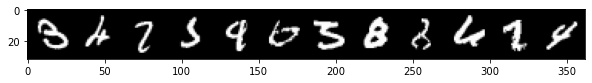

In [20]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

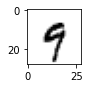

In [21]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [22]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
